# Project: Peer-to-Peer Lending Risk Modelling with Lending Club-Part 2

--by Lu Tang

## Introduction

LendingClub is the first and largest online peer-to-peer ('P2P') platform to facilitate lending and borrowing of unsecured loans. As explained by Wikipedia:

- Lending Club enables borrowers to create unsecured personal loans between $1,000  and  $40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

**The goal of this project**: Build a machine learning model that can help investor reduce the investment risk by building a portfolio with selected loans.

**Data Source** : Personal loan payment dataset from LendingClub Corp, LC, available on [LendingClub Statistics](https://www.lendingclub.com/info/download-data.action)

The dataset I am working on is from 2007 to 2019 quarter 2; In total, there are about 2.5 millions of loans in this data. Each row is one loan, and it covers an extensive amount of information on the borrower's side that was originally available to lenders when they made investment choices. 

**Note**: I used the all the data available including the recent loan data for two reasons:

1. I want to analyze all the loan data to find insight about default rate and year trends.
2. After researching, I found that for the loans that are issued in recent years, although the loan term is either 36 months or 60 months, there are many loans that are pre-paid or charged off before it is expired. Those are still the data that I can use in the model. 

The whole projects are separated in two parts, and this is part 2. 

- Part 1 Understanding and Cleaning data, Identifying investment problem

- Part 2 Choosing the best model for investors

## Part 2 Choosing the best model for investors

### Table of Contents
<ul>
<li><a href="#review">1. Review Part 1 and clarify our goal in modelling</a></li>
<li><a href="#metrics">2. Defining Error Metrics</a></li>
<li><a href="#preprocessing">3. Preprocessing the data</a></li>
<li><a href="#model">4. Fit the data in different models and analyze the result</a></li>  
<li><a href="#summary">5. Summary</a></li>    
</ul> 

**Import general library and make settings**

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# some other library are imported along with the code
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.despine(left=True, bottom=True)

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

<Figure size 432x288 with 0 Axes>

**Read the data we have cleaned in Part 1 *loans_2007_2019_cleaned.csv*, this is our target data split as train data for features column**

In [2]:
# load the data we saved from the first notebook part 1 
loans_2007_2019 = pd.read_csv('loans_2007_2019_cleaned.csv')

# view 1th rows
display(loans_2007_2019.head(1))

print('The total number of rows and columns in our cleaned 2007 to 2019 loan data is: ',loans_2007_2019.shape)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status
0,16000.0,36 months,11.14,524.89,B,8.0,RENT,65000.0,Not Verified,credit_card,VA,15.76,0.0,1.0,9.0,0.0,13484.0,37.6,14.0,f,39639.0,35900.0,3.0,4404.0,20256.0,38.1,130.0,155.0,7.0,3.0,0.0,7.0,3.0,0.0,3.0,4.0,5.0,6.0,5.0,6.0,8.0,4.0,9.0,2.0,100.0,20.0,0.0,63549.0,39639.0,32700.0,25728.0,1


The total number of rows and columns in our cleaned 2007 to 2019 loan data is:  (1023834, 52)


<a id='#review'></a>
## 1. Review Part 1 and clarify our goal in modelling

From part 1, we found the Charged Off rate for all the loans in average is 19.57%. This means **if an investor randomly choose loans to invest, he/she could have about 19% of Charged-Off rate**. 

I digged deeper and found **if a super conservative investor randomly choose ONLY A loans to invest, he/she could have about 5.9% of Charged-Off rate**.

The following table is the one I saved from Part 1 after analyzing the loan grade and returns. Let's do further analysis

In [3]:
# read investment data made from part 1.
investment = pd.read_csv('investment.csv')
# add loan grade column
investment['loan_grade']=['A','B','C','D','E','F','G'] # since I saved the data as index=False, so i need to add it back.
# view the table
investment

,Loan Grade,Average Interest Rate,Unnamed: 2,Averafe Charged-Off Rate,loan_grade
0,A,7.10%,NaN,5.95%,A
1,B,10.67%,NaN,13.28%,B
2,C,14.04%,NaN,22.14%,C
3,D,17.81%,NaN,29.85%,D
4,E,21.27%,NaN,37.87%,E
5,F,25.03%,NaN,44.78%,F
6,G,27.82%,NaN,49.48%,G


Note: From part 1, we have found the proportion of the loans between different grade are not the same, and I also mentioned that 'Charged-Off' rate does NOT mean the when the loans are charged off, investor will loss all the principal and interest, because loan payment schedul is a mortgage-like arrangement and a loan maybe charged off during the loan term. This can explain why the charged-off rate is even higher than interest rate except for A loans.

From first row, we can see if an investor put 25 dollar per loan and invest in 1000 loan, and ONLY choose A loans to invest, the average expected return is **7.1%**, but if he/she lose all the money for the loans that are charged-off, the net return is: 0.071004-0.059498 = **1.5%**. We can also calculate as following:

In [4]:
# calculate the worst case for expected return 
((0.071004-0.059498)*25*1000)/(25*1000)

0.011505999999999997

**Our goal in buidling machine learning model**

1. Our model should perform better than if an investor randomly pick up all the loans to invest, which is **to reduce the risk at least lower than 19.57%**.  

2. Our model should perform better than if a conservative investor randomly choose only A loans to invest. **Our model that have expected return higher than 7.1%**, and **for the worst case, still have expected return higher than 1.15%**

<a id='metrics'></a>
## 2. Define error metric

Before diving in and selecting an algorithm to apply to the data, we should select an error metric, and it is not always an accuracy score or AUC-ROC, it depends on the problems we are trying to solve with our model.

We're using a machine learning model to predict whether or not we should fund a loan on the Lending Club platform. Our objective in this is to make money -- we want to fund enough loans that are paid off on time to offset our losses from loans that aren't paid off. An error metric will help us determine if our algorithm will make us money or lose us money.

In this case, we're primarily concerned with **false positives** and **false negatives**. Since we're viewing this problem from the standpoint of a **conservative investor**, we need to treat false positives differently than false negatives. A conservative investor would want to **minimize risk**, and **avoid false positives as much as possible**. They'd be more okay with funding a safer loan (false positives) than missing out on opportunities (false negatives).

From part 1, we can see there is a **significant class imbalance** in the loan_status column. This causes a major issue when we use accuracy as a metric. This is because due to the class imbalance, a classifier can predict 1 for every row, and still have high accuracy. Read more on [beyond-accuracy-precision-and-recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

This means that we should **optimize** for:
- **Low fpr (false positive rate)** 

fpr = fp / (fp + tn), i.e. "among the loans that ACTUALLLY 'Charged-Off', what percentage the model is wrong." 

- **High Precision (similar with Low fpr)**

precision = tp/(tp+fp), i.e."among the loans that the model PREDICTED as 'will Fully-Paid', what percentage the model is right.

- **High tpr (true positive rate/Recall/Sensitivity) (this comes with a cost when we optimize the fpr and Precision)**

tpr = tp / (tp + fn), i.e."among the loans that ACTUALLLY 'Fully-Paid', what percentage of loans that should be funded that I would fund". 

Generally, if we want to reduce false positive rate, true positive rate will go down. This is because if we want to reduce the risk of false positives, we wouldn't think about funding riskier loans in the first place. In other words, our model will be very 'strict' on picking up the loans that it thinks will much more likely to pay off; it basically discard a lot of bad and good loans, and select only those very good ones.

I wrote my own **model metric function** to print out only the metrics we need. (The classification report and other popular metric library is not useful here, and only makes readers more confusing). 

I also wrote a function for **precision-recall curve**. I choose precision-recall curve to visualize the trade-off between the precision and recall **because this is imbalanced dataset and one class is more important than another one**. Although ROC-AUC is popular, it is not useful to solve our problem. (Read more [roc-and-precision-recall-with-imbalanced-datasets](https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/). Also [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) And [Interpreting ROC Curves, Precision-Recall Curves, and AUCs](https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/)). Also for f1_score, I did not use F1_score, because if I have a classifier which F1 score is low, we can’t tell whether it has problems with false positives or false negatives. In this case, the best way to “debug” such a classifier is to use confusion matrix to diagnose the problem and then look at the problematic cases in the validation or test dataset. (Read more [here](https://www.mikulskibartosz.name/f1-score-explained/) and read [here](https://stats.stackexchange.com/questions/49226/how-to-interpret-f-measure-values)). (At the first I actually calculate F1_score and AUC for ROC, it's high but it does not give more informative insights.)

Lastly, I wrote my own **investment portfolio return function** , i.e. if an investor invested on the loans selected selected  by my model, how much investment return (%) he/she can expect. If we only choose model based on those metric score or a confusion metrix, it is still very confusing, because for our purpose, it does not mean a model with lowesr false positive rate is the best model. With this function, we can choose a model that perform better than if the investor randomly pick up loans to invest without my model. 

**1. Define my metric function**

In [5]:
def my_metric(model, X_test, y_test):
    
    # getting predicted values
    y_predict = model.predict(X_test)
    
    # False positives
    fp_filter = (y_predict == 1) & (y_test == 0)
    fp = len(y_predict[fp_filter])
    
    # True positives.
    tp_filter = (y_predict == 1) & (y_test == 1)
    tp = len(y_predict[tp_filter])
    
    # False negatives.
    fn_filter = (y_predict == 0) & (y_test == 1)
    fn = len(y_predict[fn_filter])
    
    # True negatives
    tn_filter = (y_predict == 0) & (y_test == 0)
    tn = len(y_predict[tn_filter])
    
    # Rates
    tpr = tp  / (tp + fn)
    fpr = fp  / (fp + tn)
    precision = tp/(tp+fp)
    
    print('Confusion matrix: \n', confusion_matrix(y_test, y_predict))
    # print(classification_report(y_test,y_predict)) # we don't need this
    print('The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn): ', tpr)
    print('The False Positive Rate (1-specification)is fpr = fp/(fp+tn): ', fpr)
    print('The Precision (tp/(tp+fp)) is: ', precision)
    print('\n')

**2. Define precision-recall curves**

In [6]:
def precision_recall_curves(model, X_test, y_test):
    
    # plot Precision Recall Curve
    plt.figure(figsize=(8,6))
    
    # predict probabilities
    probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    
    # get predicted class value
    y_predict = model.predict(X_test)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    
    # plot no skill
    # I set 0.8 because our imbalanced data is roughly 80% as majority class
    plt.plot([0, 1], [0.8, 0.8], linestyle='--') 
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, color='darkorange', marker='.')
    plt.xlabel('Recall (sensitivity, or True Positive Rate)')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    
    return plt.show()

**3. Define investment return with my model**

In [7]:
def investment_return_with_my_model(model, X_test, y_test):
    
    # get predicted class value
    y_predict = model.predict(X_test)
    # reshape
    y_predict = y_predict.reshape((y_predict.shape[0], 1))
    # put it into a dataframe
    y_predict = pd.DataFrame(y_predict, index=range(0,len(y_predict)), columns=['loan_status_predicted'])
    
    # Join X_test and y_test using 'join' since they have the same index
    loans_test = X_test.join(y_test)
    
    # Then join the test dataframe with y_predict; Since it is different index, I created a 'Join' column and then use 'merge'
    loans_test['Join']=list(range(0,len(y_predict)))
    y_predict['Join']=list(range(0,len(y_predict)))
    # Merge test data with predicted data
    loans_test_with_predict = pd.merge(loans_test, y_predict, on='Join')
    
    # filter the rows that are predicted as 1
    predict_should_invest = loans_test_with_predict[loans_test_with_predict['loan_status_predicted']==1]
    
    # Among the loans predicted as 1, filter the rows thar are actually as 1
    actual_should_invest = predict_should_invest[predict_should_invest['loan_status']==1]
    
    # calculate the mistake rate, this is the same as fpr
    mistake_rate = (predict_should_invest.shape[0]-actual_should_invest.shape[0])/predict_should_invest.shape[0]
    
    # add a new column, indicating for each loan we invest 25 dollars
    predict_should_invest['invest_amount'] = 25
    
    # add a new column, calculating interest earned from this loan by multiplying interest rate per loan with the amount invested per loan
    predict_should_invest['interest_earned']=(predict_should_invest['int_rate']/100)*predict_should_invest['invest_amount']
    
    # sum the interest earned for all the loans we invested
    total_interest = predict_should_invest['interest_earned'].sum()
    
    # calculate our investment return
    investment_return = total_interest/(25*len(predict_should_invest))
    print('The investment return with this model is: ', '{:.2%}'.format(investment_return))
    
    # calculate the return for the worse case, meaning if we lost all the money from the loans that are charged-off
    #(including full amount of principal and interest, which is less likely), how much return we will get.
    investment_return_with_maxlosss = (total_interest-(mistake_rate*(25*len(predict_should_invest))))/(25*len(predict_should_invest))
    print('The investment return with this model for the worse case is: ', '{:.2%}'.format(investment_return_with_maxlosss))
    print('\n')

<a id='preprocessing'></a>
## 3. Preprocessing the data

**Encode object columns as dummy variables**

In [8]:
# select object columns
object_columns = loans_2007_2019.select_dtypes(include=["object"])

object_columns.head(1)

,term,grade,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,36 months,B,RENT,Not Verified,credit_card,VA,f


In [9]:
# Encode object columns to integer values and return a Dataframe containing the dummy columns.
dummy_df = pd.get_dummies(loans_2007_2019[object_columns.columns], drop_first=True)

# combine dummy column dataframe with original dataframe as column
loans_2007_2019 = pd.concat([loans_2007_2019, dummy_df], axis=1)

# drop original object columns
loans_2007_2019 = loans_2007_2019.drop(object_columns.columns, axis=1)

# review the result with 3 rows
display(loans_2007_2019.head(1))

print('The number of rows and columns in our machine learning model is : ', loans_2007_2019.shape)

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,16000.0,11.14,524.89,8.0,65000.0,15.76,0.0,1.0,9.0,0.0,13484.0,37.6,14.0,39639.0,35900.0,3.0,4404.0,20256.0,38.1,130.0,155.0,7.0,3.0,0.0,7.0,3.0,0.0,3.0,4.0,5.0,6.0,5.0,6.0,8.0,4.0,9.0,2.0,100.0,20.0,0.0,63549.0,39639.0,32700.0,25728.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


The number of rows and columns in our machine learning model is :  (1023834, 123)


*Not scale on our data*

Scale data is not very neccessary for this project, I have tested with the same machines learning model with standard scaled data, the results are not too much different. However, scaled data makes interpretation more difficult, I need the original test data to with interest column to calculate interest on investment.

**Train Test split**

We take 70% of the data to use as trainning data that will be fit to a model, the rest 30% of the data will be used as test data to get predicted value; we then compare our predicted value with actual value to calculate our error metric fpr and tpr.

In [10]:
features = loans_2007_2019.drop('loan_status', axis=1)

target = loans_2007_2019['loan_status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

<a id='model'></a>
## 4. Fit the data in different models and analyze the results

### 4.1 Try Logistic Regression with default papameters

A good first algorithm to apply to binary classification problems is logistic regression, for the following reasons:

- it's quick to train and we can iterate more quickly,
- it's less prone to overfitting than more complex models like decision trees,
- it's easy to interpret.

In [11]:
# creat our model
lr_mymodel_default = LogisticRegression().fit(X_train, y_train)
# use my function
my_metric(lr_mymodel_default, X_test, y_test)
investment_return_with_my_model(lr_mymodel_default, X_test, y_test)

Confusion matrix: 
 [[   325  58998]
 [   307 247521]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.9987612376325516
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.9945215177924245
The Precision (tp/(tp+fp)) is:  0.8075225353077623


The investment return with this model is:  13.19%
The investment return with this model for the worse case is:  -6.06%




**Analyze the result**

Our tpr and fpr are all very high, this means our model predict 99% of the loans that are Fully-paid that are actually Fully-paid (which is good), but also predict 99% of the loans as Fully-paid when it is asctuall Charged-off. If we check what is our prediction, we will see it's almost all as 1.

Precision is 80%, This seems high, but our target columns is a highly imbalanced class, 80% of the values are 1 and 20% of the values are 0. So 80% of precision does not mean much.

Lastly, if we use this model, we could lost 6.06% of our money.

**My stragegy to fix the problem** is to tell the classifier to penalize certain rows more by setting the class_weight parameter to balanced. This tells scikit-learn to penalize the misclassification of the minority class during the training process. The penalty means that the logistic regression classifier pays more attention to correctly classifying rows where loan_status is 0. This lowers accuracy when loan_status is 1, but raises accuracy when loan_status is 0. By **setting the class_weight parameter to balanced**, the penalty is set to be inversely proportional to the class frequencies. This would mean that for the classifier, correctly classifying a row where loan_status is 0 is 4 times more important than correctly classifying a row where loan_status is 1. (4 times is not default value, it is based on the proportionate of our loan status data)

### 4.2 Try Logistic Regression with class_weight = 'balanced'

In [12]:
# creat model, set model parameter with balanced
lr_mymodel_balanced = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
# use my function
my_metric(lr_mymodel_balanced, X_test, y_test)
investment_return_with_my_model(lr_mymodel_balanced, X_test, y_test)

Confusion matrix: 
 [[ 38777  20546]
 [ 87184 160644]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.6482076278709428
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.3463412167287561
The Precision (tp/(tp+fp)) is:  0.8866052210386887


The investment return with this model is:  10.48%
The investment return with this model for the worse case is:  -0.86%




**Analyze the result**

We significantly improved false positive rate by balancing the classes, which also reduced true positive rate. Our true positive rate is now around 65%, and our false positive rate is around 35%. From a conservative investor's standpoint, it's reassuring that the false positive rate is lower because it means that we'll be able to do a better job at avoiding bad loans than if we funded everything. However, investor can still lose 0.86% of investment.

**Using precision_recall_curves to visulize the trade off**

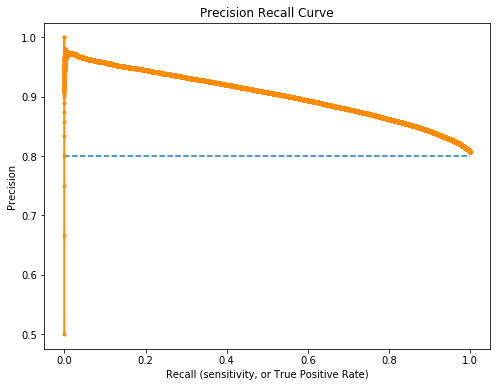

In [13]:
precision_recall_curves(lr_mymodel_balanced, X_test, y_test)

When recall is close to 1.0, precision is about 80%, this is similar in the logistic regression without balanced class in our first model. When recall is roughly 0.65, precision is about 0.89 as shown in balanced logistic regression.

**As recall reduces, precision can increase. But since there is 'missing good investment opportunity' vs 'being safer', to which point we shoud choose a model that can give best investment return, this is where my investmet portfolio function can help.** 

### 4.3  Try Random Forest Classifier with class_weight as balanced

Random forests are able to work with nonlinear data, and learn complex conditionals. Logistic regressions are only able to work with linear data. Training a random forest algorithm may enable us to get more accuracy due to columns that correlate nonlinearly with loan_status.

In [14]:
# create model, with balanced 
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=1).fit(X_train, y_train)
# use my function
my_metric(rf_balanced, X_test, y_test)
investment_return_with_my_model(rf_balanced, X_test, y_test)

Confusion matrix: 
 [[  9346  49977]
 [ 14450 233378]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.9416934325419243
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.8424557085784603
The Precision (tp/(tp+fp)) is:  0.8236240758059677


The investment return with this model is:  12.72%
The investment return with this model for the worse case is:  -4.91%




**Analysis the result**

Unfortunately, using a random forest classifier didn't improve our false positive rate. The model is likely weighting too heavily on the 1 class, and still mostly predicting 1s. Compared with Logistic Regression Balanced class, the false positive rate with Random Forest is still very high.


**My strategy**

Choose logistic regression and try to lower the false positive rate further by **assigning a harsher penalty for misclassifying the negative class**. While setting class_weight to balanced will automatically set a penalty based on the number of 1s and 0s in the column, we can also set a manual penalty. (The default penalty scikit-learn imposed for misclassifying a 0 would have been around 4, since there are 4 times as many 1s as 0s).

### 4.4 Logistic Regression with class_weight with different penalty in a for loop

In [15]:
# set model parameter with different penalty
for i in [6, 7, 8, 9, 10]:   
    # creat our model
    penalty = {0: i, 1: 1} 
    lrf_mymodel_penalty = LogisticRegression(class_weight=penalty).fit(X_train, y_train)
    # use my function
    my_metric(lrf_mymodel_penalty, X_test, y_test)  
    investment_return_with_my_model(lrf_mymodel_penalty, X_test, y_test)

Confusion matrix: 
 [[ 48188  11135]
 [132224 115604]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.4664686798908921
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.18770122886570134
The Precision (tp/(tp+fp)) is:  0.912142276647283


The investment return with this model is:  9.42%
The investment return with this model for the worse case is:  0.63%


Confusion matrix: 
 [[ 50930   8393]
 [148812  99016]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.399535161482964
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.1414796959020953
The Precision (tp/(tp+fp)) is:  0.9218594344980402


The investment return with this model is:  8.93%
The investment return with this model for the worse case is:  1.12%


Confusion matrix: 
 [[ 53789   5534]
 [171675  76153]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.3072816630889165
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.09328590934

<a id='#summary'></a>
# Summary

Different model returns different results, which one to choose depends on the investor. As explained by the precision recall curve, there is a trade off between 'missng good investment opportunity' vs 'being safer'. For this project, we **consider from a more conservative perspective and help investor reduce risk and still get decent return**. **Remember our goal for is: Choose a model that has lower than 19.57% charged off rate, and have expected return higher than 7.1% (i.e. average interest for only A loans), and for the worst case, still have expected return higher than 1.15%**.

Keeping this in mind, **I would recommend the Logistic Regression model with class_weight set as 10, because in this model:**

- **False posistive rate is: 5.4% (In plain English, this is the Charged-off rate, similar as default rate, the percentage of the loans invested that not pay you back). This is much lower than 19% loss if the investor randomly choose loans.**
- **Investing in this portfolio will have expected return is the range of of 8.04%, and the expected return for the worse case is: 2.41%.**

This gives 1% higher return and TWICE safer than if the investor only randomly choose A loans. Well, 1% higher maybe not too significant, but we all know the bank gives us interest rate like 0.1%; If there is a way we can invest more safely and get higher return, it is something worth doing. And if you invest a lot, 1% increase can give you a lot more interest. 

**If you are willing to take higher risk**, I would recomend the the Logistic Regression model with class_weight set as 6, and **your expected return will be in the range of 0.63% to 9.42%**. Not too bad, at least for the worst case, you still keep all of your principle safe with 0.63% of return.

Other things to consider:

1. I did not use other popular advanced model like SVM, Gridient Boosting and Neural Network for this data. First reason is: with Logistic Regression, I already got good results, even better than Random forest, and Logistic Regression is easier to interpret and quicker to interpret. Second reason is: I tried with other model, it never runs even if I took only a sample, the running time is very slow. 
2. To this stage, I have not written pre-process function to clean and pre-process new data to be used in the model.The test data I used is from the train-test split. It's something I can do in the furtue, and the application for the model in real life. Also more modeling project on Finance, I think Artificial Financial Advisor can be a trend for the future, it doesn't mean to replace finance manager, but another options. Thank you for reading.